In [17]:
from src.data.some_dataloader import RedditHyperlinkDataset, RedditPostDataset, RedditPoliticalPostDataset
from src.utils import train_utils, plot_utils, data_utils, heatmap, politics, topics_monthly, post_per_day_utils, general_utils
import importlib
import pandas as pd
import powerlaw
importlib.reload(plot_utils)
importlib.reload(data_utils)
importlib.reload(politics)
importlib.reload(train_utils)

<module 'src.utils.train_utils' from '/Users/katiahaefliger/Desktop/EPFL/MA 1/ADA/Project/ada-2025-project-othertagada/src/utils/train_utils.py'>

# R/GamerGate
Gamergate was an online harassement campaign against feminism, diversity, and progressivism in video game culture, that was present on multiple online platforms, including reddit. Two subreddits where created in response: r/KotakuInAction, r/GamerGhazi, which exclusively are about this topic. The trigger for this event was a blog post published in August 2014 by Eron Gjoni, the ex-partner of game developer Zoë Quinn, in which he made allegations about their personal relationship.

## 0. Datasets used

We used the additional dataset with post content but without link to enrich the analysis.

In [25]:
hyperlink_dataset = RedditHyperlinkDataset()
hl_data = hyperlink_dataset.data

In [2]:
post_dataset = RedditPostDataset()
post_data = post_dataset.data

## 1. Look at the actors

### 1.1 Selection of subreddits

We restrain the dataset to relevent subreddits to this aim we select the top subreddits with the most interactions (links ingoing and outgoing) with our two principal actors to have a selection of subreddits involved in the drama. To do so we very simply calculated for each subreddit the total number of links where r/kotakuinaction and r/gamerghazi appear as source or target. This sum was done seperatedly for the two of them so our analysis was not skewed by the fact that r/kotakuinaction has more links in total. Some subredits appear in both their top ten but some are only present for one.

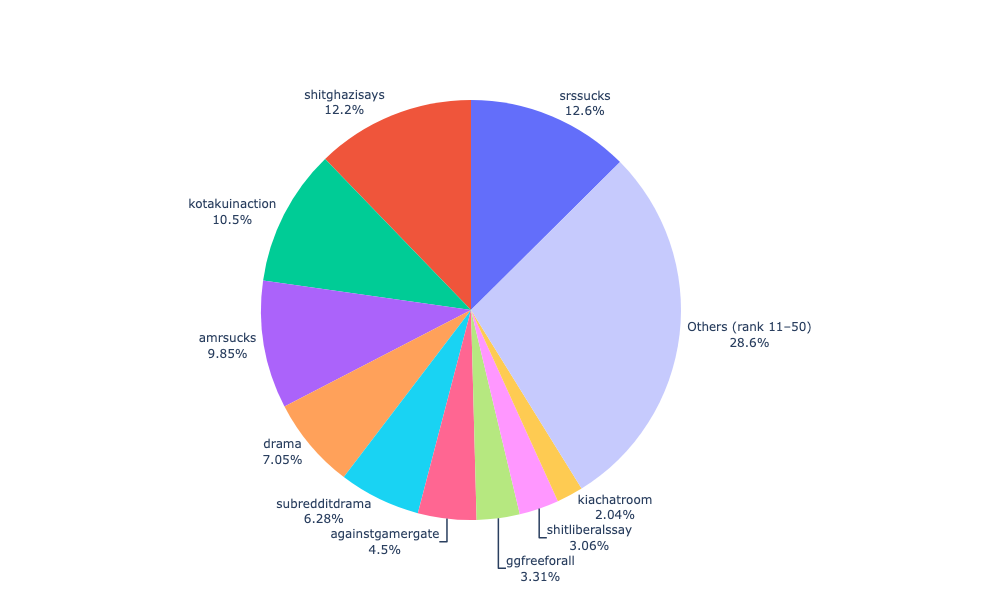

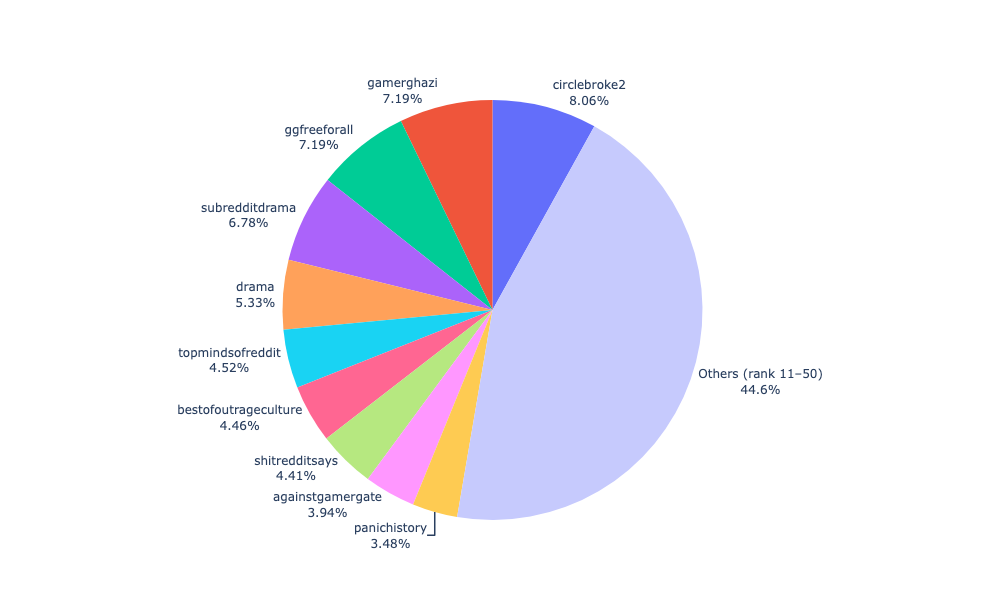

In [26]:
plot_utils.plot_interactions(hl_data, 'gamerghazi', n=50)
plot_utils.plot_interactions(hl_data, 'kotakuinaction', n=50)

So only these 16 subreddits represent a good volume of the links that our 2 main actors share (71.4% and 55.4% for gamerghazi and kotakuinaction respectively). Knowing that we have a total of 16 subreddits in the dataset, it is interesting to note that only a few restrained communities have the bulk of links to kiA and giA. These could be seen as subreddits that are part of a very specific online echo chamber.

We crop our datasets so that they only include these subreddits

In [27]:
gamerghazi_subs = data_utils.top_connected(hl_data, 'gamerghazi', n=10)
kotakuinaction_subs = data_utils.top_connected(hl_data, 'kotakuinaction', n=10)

subs_of_interest = (set(gamerghazi_subs.index) | set(kotakuinaction_subs.index) | {'gamerghazi', 'kotakuinaction'})
hl_data_cropped = hl_data[hl_data['SOURCE_SUBREDDIT'].isin(subs_of_interest) & hl_data['TARGET_SUBREDDIT'].isin(subs_of_interest)]

print("selected population : \n", hl_data_cropped['SOURCE_SUBREDDIT'].unique())



selected population : 
 ['subredditdrama' 'srssucks' 'circlebroke2' 'drama' 'shitredditsays'
 'amrsucks' 'kotakuinaction' 'panichistory' 'gamerghazi'
 'againstgamergate' 'shitghazisays' 'kiachatroom' 'topmindsofreddit'
 'shitliberalssay' 'ggfreeforall' 'bestofoutrageculture']


Let's see how these subreddits interact with our main actors

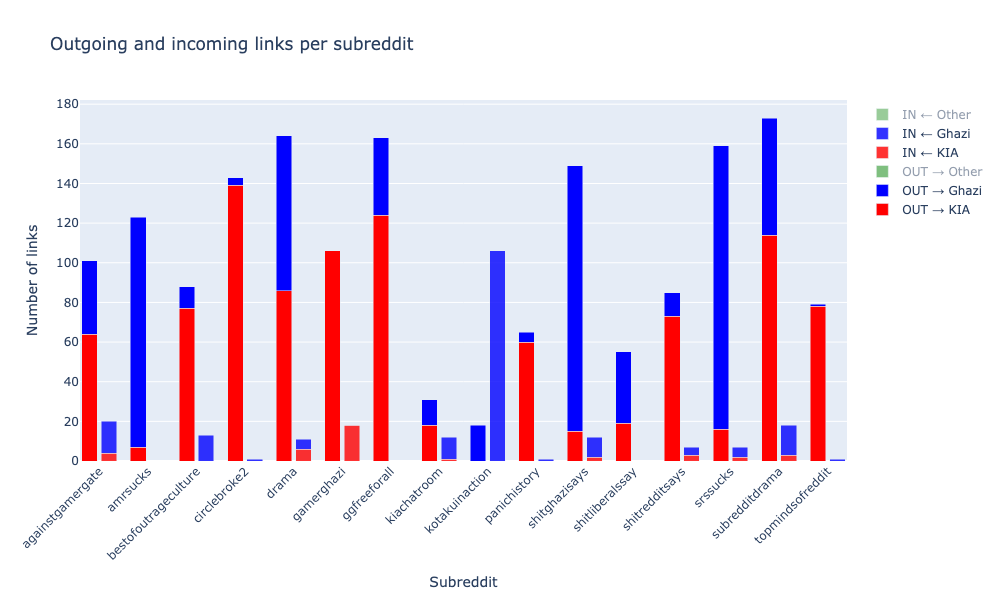

In [28]:
## BAR PLOT LINKS ##

plot_utils.plot_stacked_bar_chart(hl_data_cropped, html_output=True)

We can clearly see that most subreddits send more links than they receive from KiA and Ghazi. 

This also helps us better understand the nature of one of our actors. Gamerghazi presents much more links towards Kia than from them, which is in explained by its nature of G"counter-attack" to gamergate. They are not the direct target of the gamergaters, but more like an opposition.

### 1.2 Population of these subreddits

1.2.1 First Let's have a look at the populations that make up reddit in general.

We want to understand how users interact with the reddit platform to better analyze the gamergate. First let's look how strongly power users (users that posted a lot in the subreddits related to the gamergate) dominate the discourse. In the graph below we see the number of posts per user in the 15 subreddits of interest. The graph seems to follow a power law distribution.

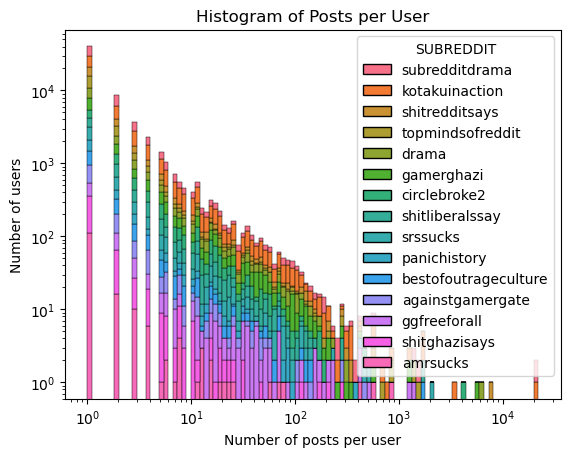

In [ ]:
## Histogram nb post per user ##
plot_utils.plot_histogram_nbposts_per_user(post_data, subs_of_interest)

Let's see how the powerlaw coeffcient would be.

In [ ]:
usersposts_fit = powerlaw.Fit(post_data.groupby("USERNAME").size().values, discrete=True)
print(f"\nxmin {usersposts_fit.xmin}\nalpha {usersposts_fit.alpha}")

Calculating best minimal value for power law fit
xmin progress: 99%
xmin 2.0
alpha 1.911816831146249


An alpha value of 1.91 would imply that there is no mean and variance and the power users fully dominate. But hold on: A lognormal distribution is also heavy tail looks also very similar. Let's look if it's really a power law distribution or if a lognormal distribution is more likely.

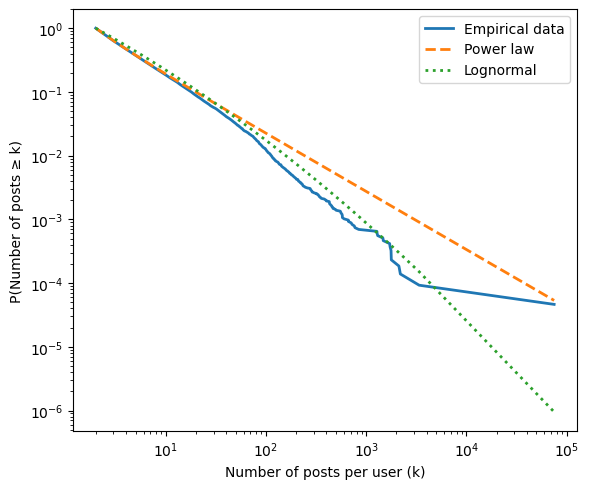

Comparaison of power_law and lognormal - R: -72.90403776127346, p: 9.805912475948022e-14
Comparaison of truncated powerlaw and lognormal - R: -45.177355398085275, p: 0.0002688447200109613
Lognormal mu: -8.061463762108822, sigma: 3.3496036565801433


In [ ]:
plot_utils.plot_userposts_ccdf(usersposts_fit)
R, p = usersposts_fit.distribution_compare("power_law","lognormal")
print(f"Comparaison of power_law and lognormal - R: {R}, p: {p}")
R, p = usersposts_fit.distribution_compare("truncated_power_law","lognormal")
print(f"Comparaison of truncated powerlaw and lognormal - R: {R}, p: {p}")
print(f"Lognormal mu: {usersposts_fit.lognormal.mu}, sigma: {usersposts_fit.lognormal.sigma}")

A p-value of less than 0.05 means that both comparaisons are statistically significant. An R value smaller than 0 means the latter distribution is more probable, which means that the lognormal distribution is vastly more probable than both the truncated and non truncated power law distribution. A sigma value bigger than 3 for the lognormal distribution still indicates that there is a strong heavy tail.

The lognormal distribution is called like that because if we take the log of the datapoints, we would get a normal distribution. The lognormal distribution is a right skewed distribution that is the statistical realization of the multiplicative product of many independent random variables. This means that there are factors that increase multiplicatively users engagement. Like with the power law, most users are "light" users who only posted a few times and there are few "power" users that contributed a large amount to the content of the subreddits. However in the lognormal distribution these power users cannot grow indefinitely like in the power law, so their contributions are very important but they do not fully dominate the discorse. This makes sense as most users are human (not bots) and cannot increase their investement indefinitely.

"Light users", while rare posters, might also still look at a lot of posts and might be very active in the act of reading and could therefore be seen more as spectators. Power users could be seen more like the leaders of the subreddits.

1.2.2 Is there a difference in negativity bewtween power user and light user ? 

To this purpose we realize a t ttest with the features is_power_user = 1 if the user posted more than 50 posts in the period and in subreddits of interest and is_power_user = 0 if he posted less than or equal 50 posts. To calculate the mean sentiment we only take posts with links (i.e. main dataset) into consideration.

We use a Welch’s t-test, as we cannot assume that both groups have equal variance (Users with very few posts have a much higher variance in the estimated mean).

In [ ]:
general_utils.t_test_negativity_users(post_data, hl_data, subs_of_interest, threshold=50)

Nb of users with 1 post: 8419
Nb of users with 2 posts: 2803
Nb of power users (> 50 posts): 469, Nb of newbies (<= 50 posts): 17871
t_stat: 1.385608752740333, p_val: 0.16588325523694653


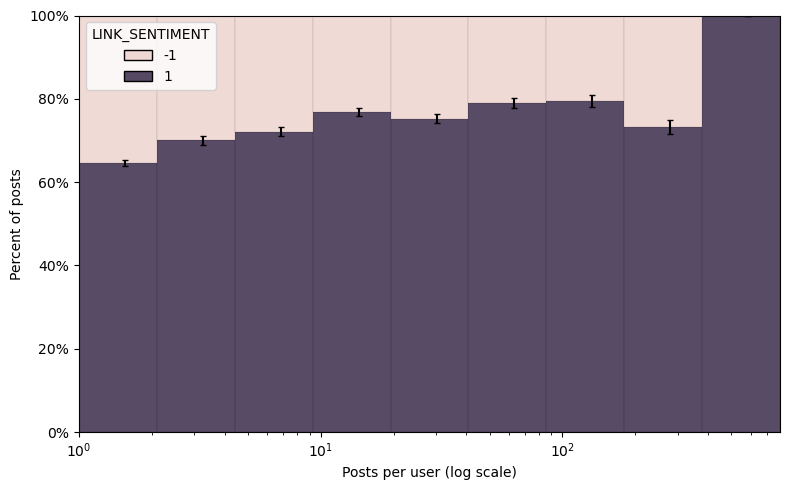

In [ ]:
plot_utils.plot_posts_percent_positive_by_posts_per_user(post_data, hl_data, subs_of_interest)

As our p value is not smaller than 0.05, we cannot reject the null hypothesis that the link sentiment average for power users and light users is identical. Power users and light users are similarly negative.

1.2.3 Which subreddits are more moderated?

To see in which subreddits the moderation is more active, we can use our extended dataset and check in which percentage of posts the body content is "\[removed]". Indeed, while posts deleted by the user itself are marked as "\[deleted]", posts removed by admins or moderators are marked as "\[removed]".

Most of the moderation is done by the moderators. Users who create subreddits automatically become their moderators. They can define the rules of the subreddit, can nominate other users to become moderators, and can delete posts. Moderators in general have lots of freedom in the way they do moderation. Admins on the contrary are reddit employees. Until around 2014, they only did the most basic moderation to be able to keep the site running, like deleting spam or removing illegal content. By 2014 however, reddit admins began to moderate a bit more strictly and imposed some new moderation rules. This change of policy was also due to events like the Gamergate happening. Posts can also be deleted by bots, but the bots are in turn controlled by one of these two groups.

The plot below shows the percentage of posts deleted by moderators by subreddit. To interpret this graph, it is probably safe to assume that most posts were removed by moderators (and not admins).

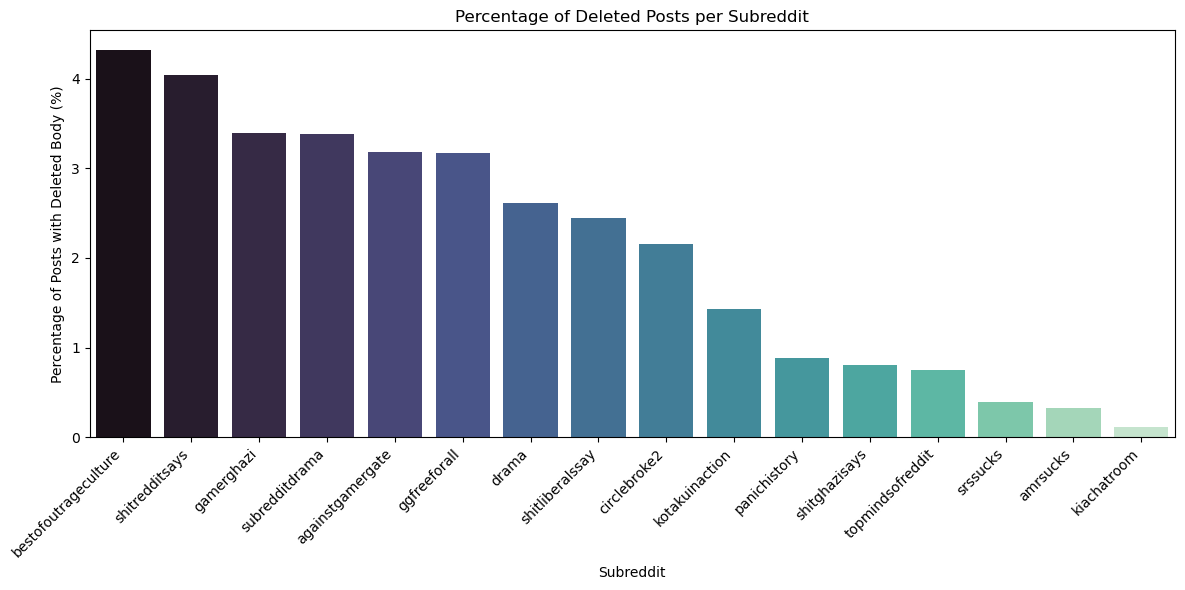

In [ ]:
plot_utils.plot_posts_with_deleted_body(post_data, byUser=False, byModerator=True)

This plot is very interesting. On the right side we see the subreddits that are mostly unmoderated. r/kiachatroom (kia=kotakuinaction), r/amrsucks (amr=againstmensright), r/srssucks (srs=shitredditsays) and r/shitghazisays (ghazi=gamerghazi) are all subreddits on the side of "r/kotakuinaction", the side of the attackers and initiators of the gamergate.
On the contrary, most strongly moderated subreddits e.g. r/shitredditsays, r/gamerghazi, r/againstgamersgate are on the side of the defenders. This makes lots of sense, as the subreddits who fight against harassment will moderate their own posts, while the attackers will not.

Of course this is only my best guess. Technically less moderation could also mean that the users behave better in these subreddits. But given the whole context of the story, this is much more unlikely. Since the text of removed posts is redacted, there is no way to prove it easily.

1.2.3 Similarity between selected subreddits

To understand better how the selected subreddits interact we first need to understand how their communities of users overlap (or don't!) We compute the Jaccard Similarity between each subreddit to construct a heatmap of user similarity between subreddits in a very intuitive way.

The Jaccard index measures the similarity between two sets by dividing the intersection of the sets by their union.
$$J(A,B)= \frac{A\cap B}{A\cup B}$$
So subreddits with a higher proportion of overlapping users will have a higer Jaccard index.

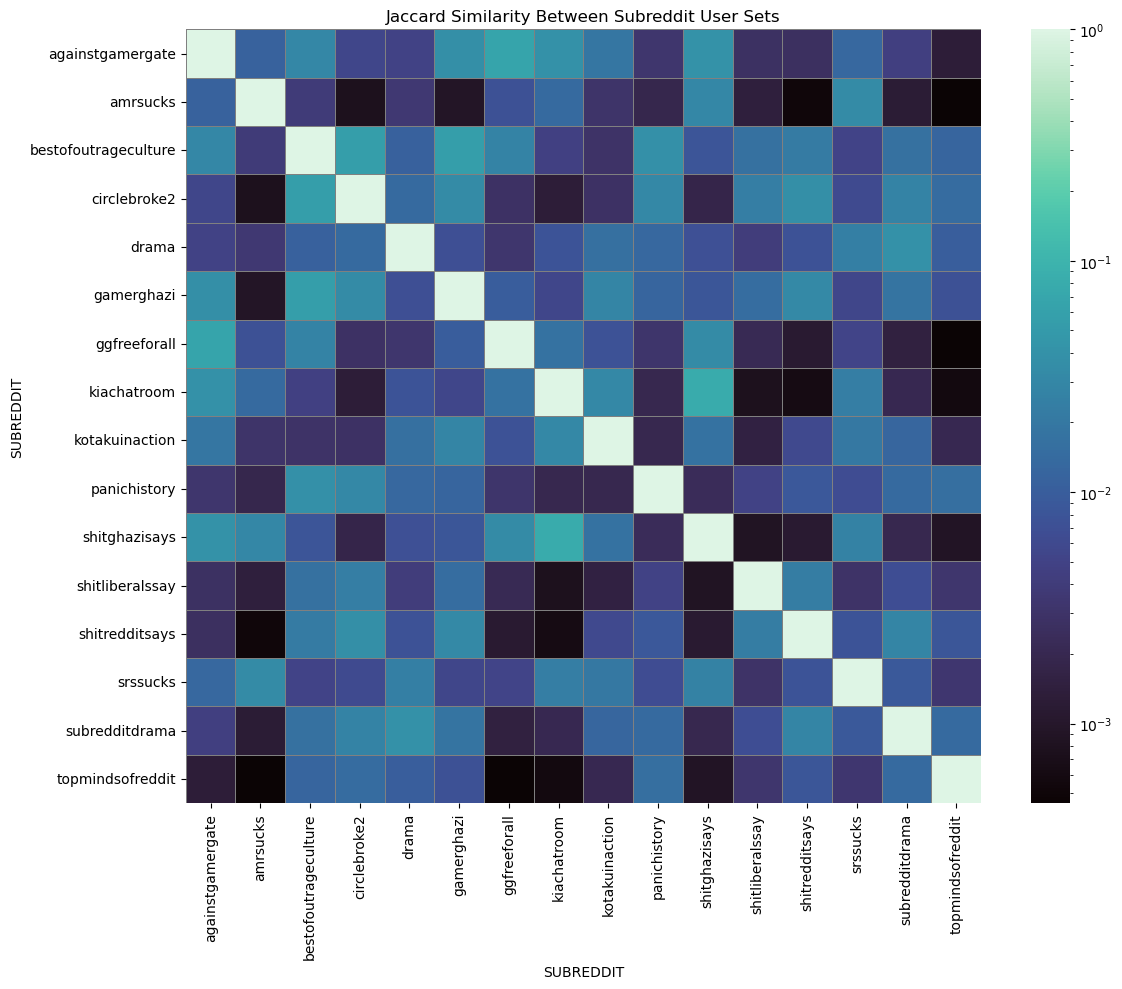

In [ ]:
heatmap.heatmap_user_in_commun(post_data)

The heatmap uses a logscale to color the values, the Jaccard similarity gives very low values that are hard to distinguish without a helpful log scaling. The low values are due to the sizes of the user set for each subreddit that are very big and with globally low overlapping. This is not suprising, as seen previoulsy, most users are light user and will not be seen on multiple subreddits.

For each subreddit, some users look to be part of the other subreddits. This is not that surprising as these subreddits were chosen for the high interaction counts with our two main subreddits. But this tells us that in addition to the high link rate, these subreddits do have similar communities.
r/kotakuinaction and r/gamerghazi don't have the most similarity, we have more mixing of users on tertiary subreddits made for discussion.
r/topmindsofreddit is very critical of r/kotakuinaction but is more sympathetic to r/gamerghazi, which is reflected in the heatmap where the similarity is very low for r/kotakuinaction but higher for r/gamerghazi.

## 2. Can negativity be predicted ?

As discussed before, this story is one of intense harassment, a huge part of managing these types of hate compaigns is content moderation. Nowadays content moderation relies mainly on models trained to detect hateful speach. Considering the cleaving topics discussed in gamergate, here we chose to consider a negative link from a subreddit to another as a sign of hate.

### 2.1 How negative is GamerGate ?

As a hate compaign we expect subreddits involved in the conflict to be more negative than reddit as a platform globally, but let's verify this assumption to make it a fact before going further. We compare the average negativity of the subreddits of interest against the one on Reddit in a global sense.

In [ ]:
gamergate_subs = subs_of_interest

large_gamergate_df, restricted_gamergate_df = data_utils.get_large_and_restricted_df(hl_data, gamergate_subs)

In [51]:
#BAR PLOT OF NEGATIVITY RATIO OF SUBREDDIT/GLOBAL LINK SENTIMENT AVERAGE#
plot_utils.plot_link_neg_frac(hl_data, large_gamergate_df)
plot_utils.plot_link_neg_frac_per_subs(large_gamergate_df, gamergate_subs)


So much negativity... but yay our assumption was verfied!

It can also be interesting to observe the negativity sent by a subreddit and compare it to the one it receives. With this analysis, we could determine in a naive way which subreddits are more aggressive in their speach and the one that are more victims of this aggressivity. Here we will simply classify the bullies and the bullied by observing which fraction is higher between the outgoing and incomig negative links for each subreddit.

In [52]:
plot_utils.plot_in_and_out_neg_link_frac_per_subs(large_gamergate_df, gamergate_subs)

Here we can observe the following looking at the difference between the incoming and outgoing negativity percentage :

The more aggressive subreddits are : amrsucks, circlebroke2, drama, srssucks, subredditdrama.\
Two of those subreddits are clearly pro-gamergate subreddits but the others are more subreddits that debate and reacted a lot about the gamergate movement without really being on one side or another.\
The most "bullied" subreddits would be : panichistory, shitredditsays, bestofoutrageculture, againstgamergate, gamerghazi.\
Four of them are anti-gamergate subreddits and the other is again more of a neutral one.

So we can again see the two sides in separate categories and it makes a lot of sense. The attackers leading a harassment campain would surely spread negativity in the communities the most and the defenders would also collect more of this negativity. It can be explained by the moderation we talked about earlier as well, where we discovered that it is more common to moderate content on the defender side than on the attacker side.

### 2.2 Predictions of link sentiment

To detect negativity we train a model of logistic regression on the hyperlink dataset (the total dataset not the one of only the selected subreddits).

##### Logistic Regression

Logistic regression is a supervised ML algorithm used for binary classification problems that uses the sigmoid function to convert inputs into a probability between 0 and 1. The model transfrom the linear regression function continuous value output $y$ into categorical value. 
The sigmoid function is defined as 
$$ \sigma(y) = \frac{1}{1 + e^{-y}} $$
where  $ y = \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p $     is the output of the linear regression model with $\beta_1, \beta_2, \cdots, \beta_p $      representing the coefficients (weights) of the features $x_1, x_2, \cdots, x_p$         and $\beta_0$ the bias term known as intercept.


For this analysis, we used the following text properties of the posts : 

"chars_no_ws", "frac_special","num_words","num_long_words",\
"avg_word_len", "frac_stopwords", "num_sentences", "num_long_sentences", \
"avg_chars_sentence","avg_words_sentence", "automated_readability"\
"vader_pos","vader_neg",\
"LIWC_Swear","LIWC_Affect","LIWC_Anger", "LIWC_Sexual"

The first 11 stylistic linguistic features would help us show how relevant the structure of a speech is in the prediction of its sentiment. We could determine if a text with an attributed sentiment tend to follow a specific structure or to have a certain complexity.

VADER values are used as well. Valence Aware Dictionary and sEntiment Reasoner is a sentiment analysis tool which is designed to analyze social media text and informal language. It is best at detecting sentiment in short pieces of text like tweets, product reviews or user comments which contain slang, emojis and abbreviations. 

Linguistic Inquiry and Word Count (LIWC) Analysis is a computational content analysis methodology that quantifies psychologically, cognitively, and socially relevant language features in free-form text. It offers 118 categories for which the statistical outputs of a text is represented as :  

$$
\text{Category Score} =
\frac{\text{Number of words in category}}
     {\text{Total number of words in text}}
\times 100\%
$$

In our dataset, only 65 categories are available and we chose to select four of them which have the most potential to be indicators of a negative sentiment in our selected communities.

(LIWC Analysis is a computational method that categorizes text into validated linguistic and psychological dimensions.)

Let's first naively plot pairwise relationships in the dataset to see if we can identify any correlation among our chosen features or with a feature and the link sentiment we would like to predict later.

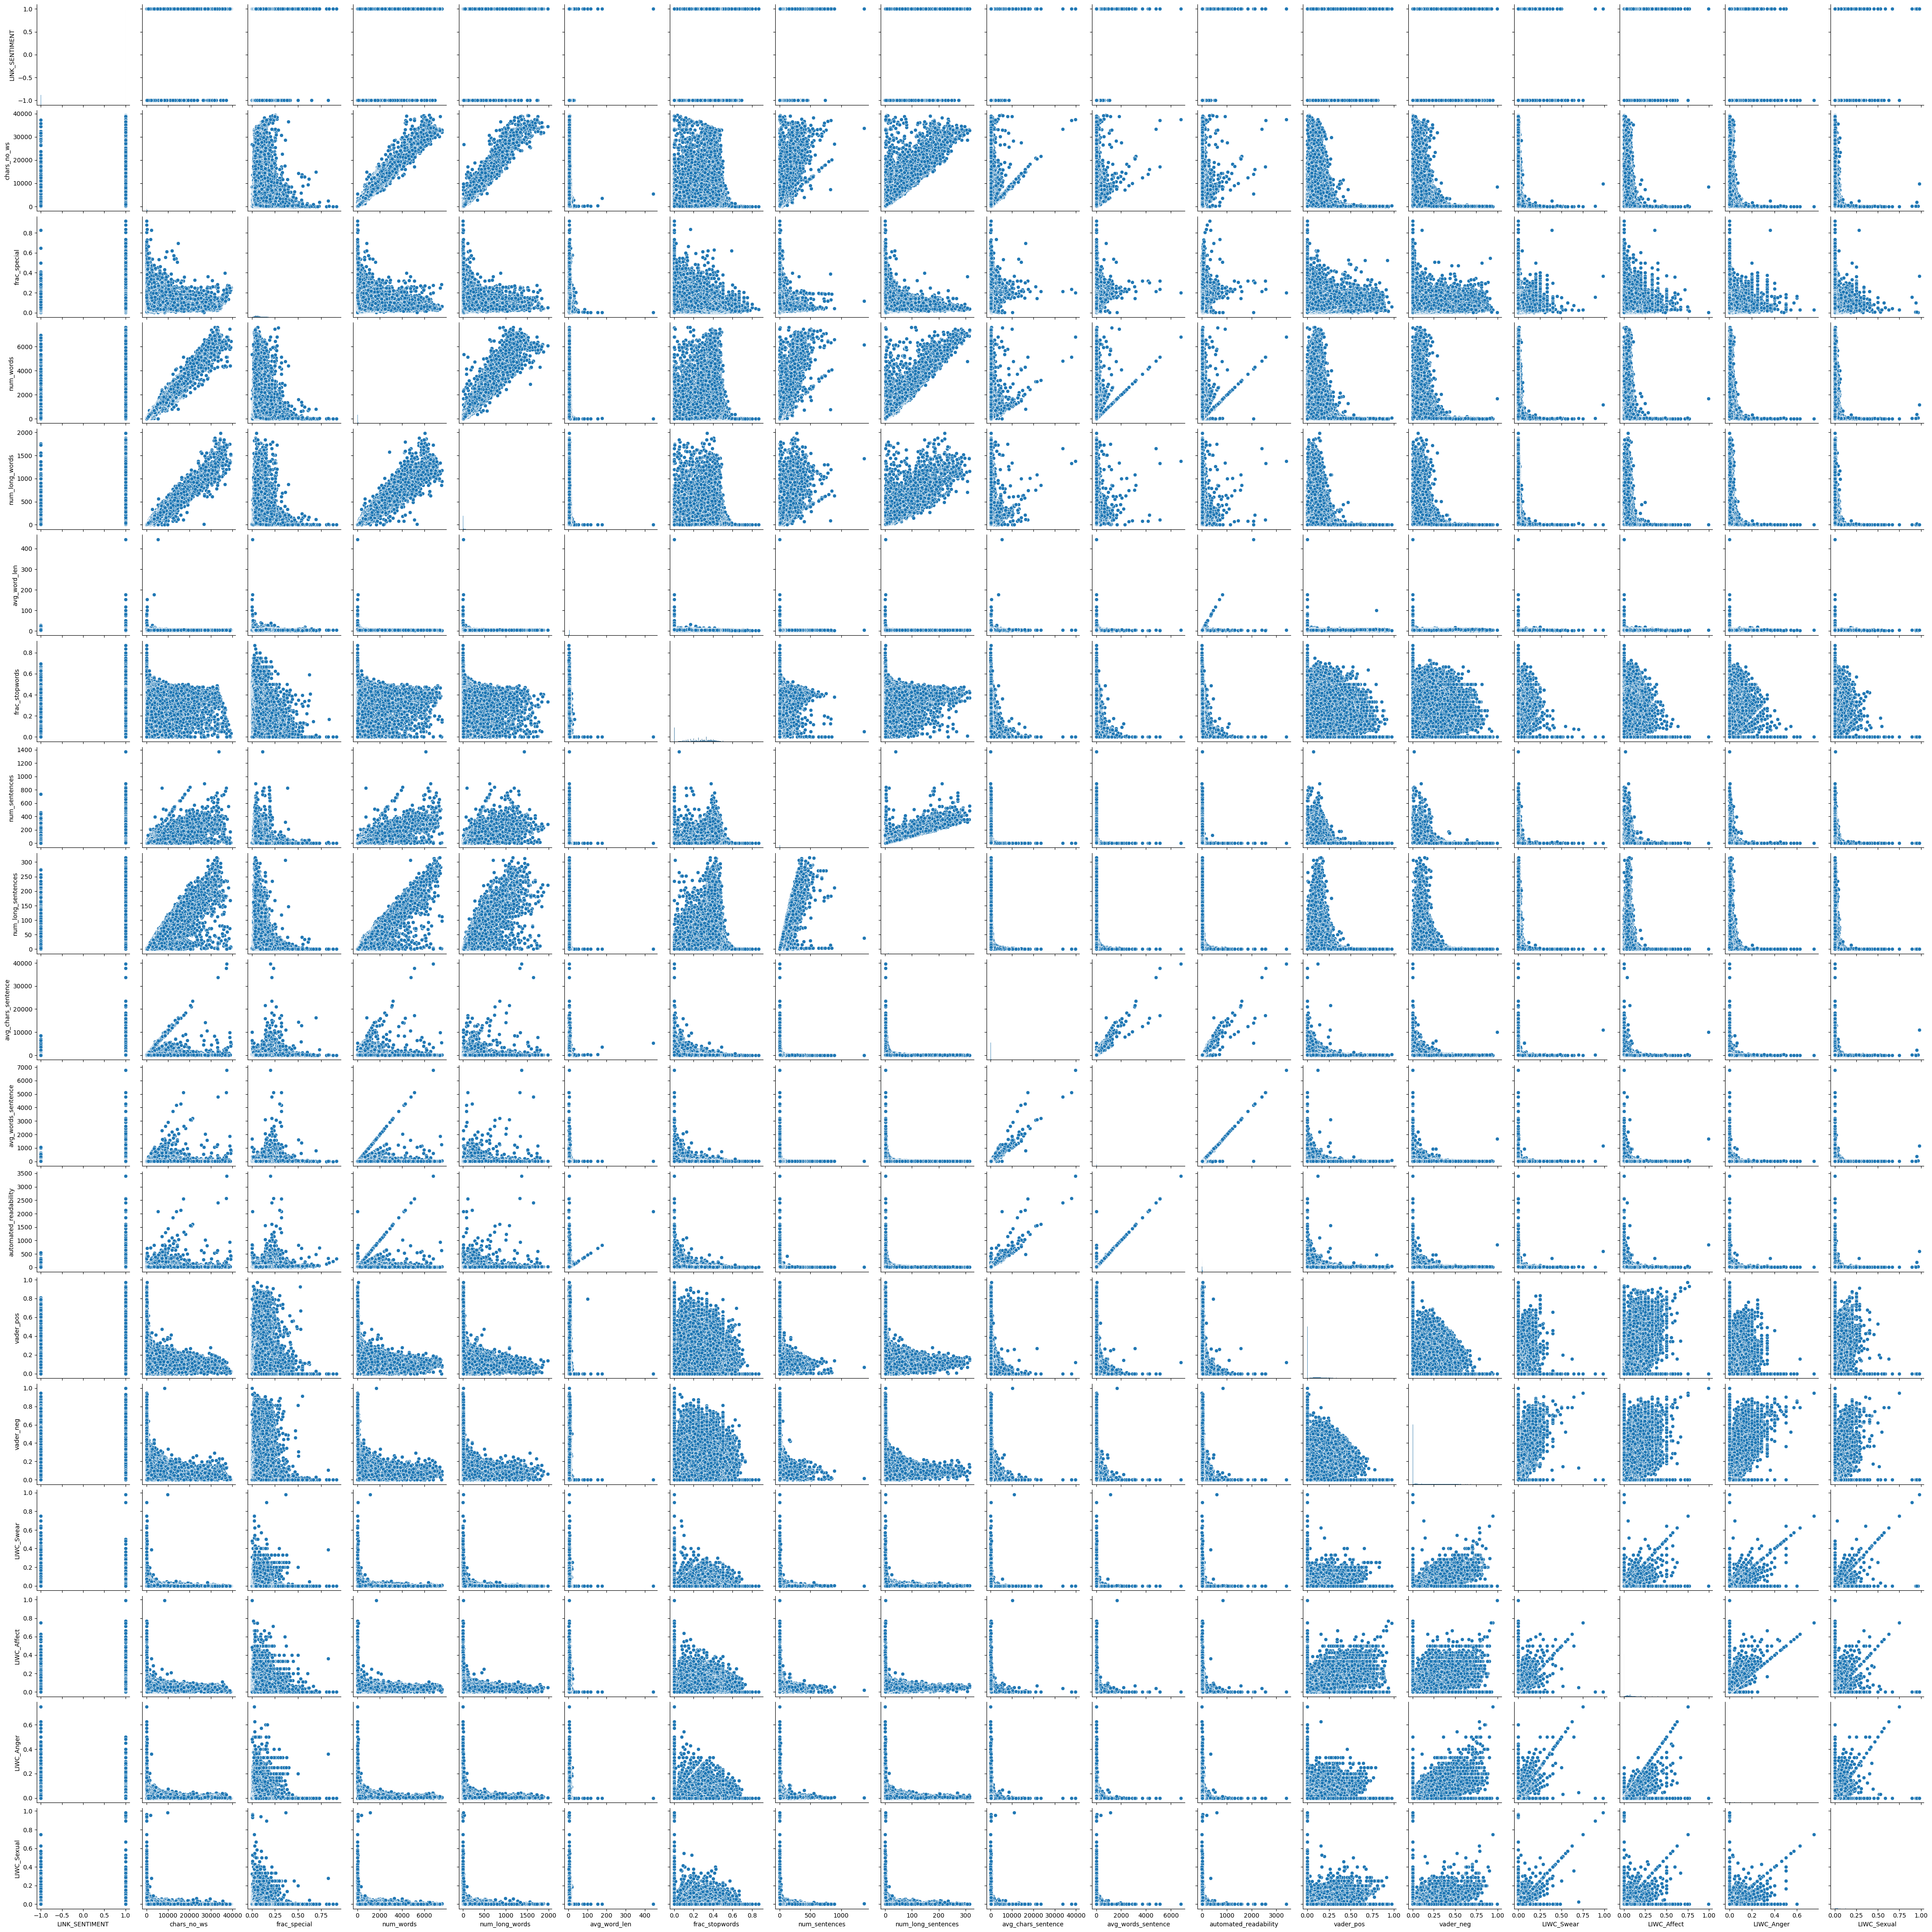

In [ ]:
import seaborn as sns

features_to_compare_whole_df = hl_data[["LINK_SENTIMENT", "chars_no_ws", "frac_special","num_words",\
                                            "num_long_words","avg_word_len", "frac_stopwords", "num_sentences",\
                                            "num_long_sentences", "avg_chars_sentence","avg_words_sentence",\
                                            "automated_readability", "vader_pos","vader_neg",\
                                            "LIWC_Swear","LIWC_Affect","LIWC_Anger", "LIWC_Sexual"]]

sns.pairplot(features_to_compare_whole_df)


This plot is a bit hard to read but the main conclusion is here :

We find the obvious correlation between features such as the number of words in a sentence with the number of characters in a sentence.
But we notice one correlation between automated readability with the average number of characters in sentences and the average number of words in a sentence as well. It seems to tell that sentences with more words tend to be more complicated to understand and needs for someone to have a better level of language to comprehend the text.\
The Automated Readability Index is indeed a readability test that that gauges the level of education needed to understand a piece of writing and looking at its formula :

$$
ARI = 4.71 \left( \frac{\text{characters}}{\text{words}} \right)
+ 0.5 \left( \frac{\text{words}}{\text{sentences}} \right)
- 21.43,
$$
it confirms our observation. We find the average number of words in a sentence and the average word length which is just an affine (linear) function of the average number of characters in a word.\
Other than the ones we just discussed, we are not able to identify any other correlation clearly.



Let's train our regression model and see how well we can predict the link sentiment of our dataset.

#### Logistic Regression for link prediction

In [ ]:
### Logistic Regression for hl_data with feature_cols

feature_cols = ["chars_no_ws", "frac_special","num_words",\
                    "num_long_words","avg_word_len", "frac_stopwords", "num_sentences",\
                    "num_long_sentences", "avg_chars_sentence","avg_words_sentence",\
                    "automated_readability", "vader_pos","vader_neg",\
                    "LIWC_Swear","LIWC_Affect","LIWC_Anger", "LIWC_Sexual"]

tr_set, te_set = train_utils.train_test_set(hl_data)
X_tr, y_tr, X_te, y_te = train_utils.data_scaling_for_training(tr_set, te_set, feature_cols, None)

In [ ]:
# simple Logistic Regression with statsmodels
logistic_reg, pred = train_utils.sm_log_reg(X_tr, y_tr, X_te, y_te)

Optimization terminated successfully.
         Current function value: 0.640190
         Iterations 7
Test accuracy =  0.807097345338909
                           Logit Regression Results                           
Dep. Variable:         LINK_SENTIMENT   No. Observations:               686790
Model:                          Logit   Df Residuals:                   686773
Method:                           MLE   Df Model:                           16
Date:                Sun, 21 Dec 2025   Pseudo R-squ.:                  -1.030
Time:                        10:34:56   Log-Likelihood:            -4.3968e+05
converged:                       True   LL-Null:                   -2.1656e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0359      0.020     -1.771      0.076      -0.076       

Training on the whole dataset, we get an prediction accuracy of 0.807 which is pretty satisfying. Now let's see how well the model predict the outgoing link sentiment of each of our selected subreddits.

In [53]:
plot_utils.inter_plot_pred_accuracy_per_subs(te_set, pred, gamergate_subs, "Prediction accuracy per subreddits (hl_data)", "docs/assets/pred_accuracy_per_subs_hl_data.html")

/Users/maguettediouf/Documents/TheOtherTagADA/ada-2025-project-othertagada/src/utils/plot_utils.py:554: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



It is clearly less satisfying... 
The accuracy is less than 0.8 for all subreddits and even less than 0.5 for three of them. 
Since we trained on the whole dataset, our model is not fitting all the data from the selected subreddits very well. It represents only a small fraction of the whole dataset.
However, among the subreddits with the most accurate predictions, we can find drama, circlebroke2 and subredditdrama, the same that were classified as "bullies" in our previous analysis but were actually not in a particular side. Why is that ?

Let's look at this next plot to get a better understanding.

In [54]:
plot_utils.plot_out_pos_neg_link_per_subs(large_gamergate_df, gamergate_subs)

The answer is actually very simple. They are among the most active subreddits of our selection, which means that they will have more impact on the model that we trained than the other smaller subreddits with only a few posts on their account.

To go futher with this analysis we want to figure out which feature had the most weight in the decision making of our model. This is where we introduce the feature coefficient of the model that will help us determine the importance of each feature and in which direction they lead us (positive or negative). 
\
\
But, to keep things a little bit more interesting, let's train an other model but with only the large_gamergate_df. That way we can compare the importance of the features in the link sentiment prediction of our chosen gamergate-related subreddits and of Reddit as a whole.

In [ ]:

train_set, test_set = train_utils.train_test_set(large_gamergate_df)
X_train, y_train, X_test, y_test = train_utils.data_scaling_for_training(train_set, test_set, feature_cols, None)


In [ ]:
log_reg, prediction = train_utils.sm_log_reg(X_train, y_train, X_test, y_test)


Optimization terminated successfully.
         Current function value: 0.575102
         Iterations 6
Test accuracy =  0.7421948569358928
                           Logit Regression Results                           
Dep. Variable:         LINK_SENTIMENT   No. Observations:                55216
Model:                          Logit   Df Residuals:                    55199
Method:                           MLE   Df Model:                           16
Date:                Sun, 21 Dec 2025   Pseudo R-squ.:                 0.02191
Time:                        09:54:21   Log-Likelihood:                -31755.
converged:                       True   LL-Null:                       -32466.
Covariance Type:            nonrobust   LLR p-value:                2.026e-293
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4453      0.106     -4.185      0.000      -0.654      

In [55]:
#plot of accuracy#
plot_utils.inter_plot_pred_accuracy_per_subs(test_set, prediction, gamergate_subs, "Prediction Accuracy per gamergate subreddits (gamergate_subs)", "docs/assets/pred_accuracy_gamergate_subs.html")

/Users/maguettediouf/Documents/TheOtherTagADA/ada-2025-project-othertagada/src/utils/plot_utils.py:554: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



The overall accuracy is lower (0.742) than the previous one but the accuracy per subreddit shows a little improvement : only 4 are under 0.7 against 10 in the previous model.

### 2.3 What are signs of negativity on reddit?

##### Feature importance and significance

The logistic regression model is useful not only to classify a link as negative or positive but also to give us a glimpse into which features are the most useful in the classification and if their presence has a positive or negative impact on the link sentiment.

In [56]:
coef_dataf = plot_utils.plot_feature_coef_and_significance(logistic_reg, feature_cols, "Logistic Regression Feature coefficients (hl_data)", "docs/assets/feature_coef_hl_data.html")

plot_utils.feature_coef_significance_grid(coef_dataf, "Logistic Regression Feature significance (hl_data)", "docs/assets/feature_significance_hl_data.html")

Here we have the following :

- A bar plot of the logistic regression feature coefficient in a descending order,
- A grid of these coefficient also indicating the significance of the feature in the model.

Among the most important features in a positive prediction we have : automated readability, num_words, vader_pos\
For a negative prediction there are : LIWC_Anger, avg_words_sentence, LIWC_Swear

Knowing the VADER indicator definition, it is not surprising to observe its weight in the positive top 3. The automated readability being top 1, we could make the asssumption that links containing more "complicated" text tend to be classified as positive. It could be that the texts written with negative intent are incline to be less elaborated and complex. Probably because the majority of the negatively classified posts contains insulting and aggressive speech with swears and are not negative in a constructive way like a negative review might be for example. This could explain the strong negative weight that the LIWC_Anger and LIWC_Swear features gained in the trained model. \
Only 4 features are here considered to be insignificant (char_no_ws, num_long_sentences, num_sentences, avg_chars_sentence).


### 2.4 Linguistic characteristics of Gamergaters 

Let's evaluate the features of our second model now.


In [57]:
coef_df = plot_utils.plot_feature_coef_and_significance(log_reg, feature_cols, "Logistic Regression Feature coefficients (gamergate_subs)", "docs/assets/feature_coef_gamergate_subs.html")

plot_utils.feature_coef_significance_grid(coef_df, "Logistic Regression Feature significance (gamergate_subs)", "docs/assets/feature_significance_gamergate_subs.html")

Among the most important features in a positive prediction we have : automated readability, avg_chars_sentence, num_words\
For a negative prediction there are :  avg_words_sentence, avg_word_len, LIWC_Anger

Again without any surprise, anger is a good predictor of negative sentiment in a link. Gamergate involved a lot of threats and abuse as we previously stated. It triggered a very vivid reaction which was aggressive. The average number of words in a sentence appears as well once again in the negative prediction. It indicates a characteristic of the negative posts : the more words in a sentence, the more negative it gets.

Automated readability still plays an important role in the decision of a positive link sentiment. As the positive link sentiment also include neutral posts, the large weight of automated readability could be explained by the role of some subreddits such as r/subredditdrama that might just report some drama that occurs on the platform without taking part. Just stating some facts and sharing the newest conflicts there might be which would be categorized as neutral posts.

It's intriguing to notice LIWC_Swear has now a small positive weight. We have to remind ourselves that a positive link sentiment do not necessarily means that the post's text is friendly. It could also mean that it is neutral, it doesn't have any good or bad intentions. We could interpret that as a way of speaking and writing that is just more crude but not mean in our subreddits of interest.


## 3. Gamergate and the alt-right sphere

GamerGate has been widely analysed post mortem and is now considered a text book exmaple of manifactured online outrage. Pushing communinities to more extrem views, more precisely more extrem political views. Gamergate is inherently political in its premice of harassement compagne agains women in gamer spaces.\
To this aim we look at users from what we consider 'attacker' subreddits and at users from political subreddits, in particular right to alt-right subreddits.

We selected as attacker subreddits :
* shitghazisays
* kotakuinaction
* amrsucks
* srssucks
* kiachatroom

We selected as right/alt-right extremism subreddits :
* conservatism
* the_donald (Donald Trump subreddit)
* conspiracy 

and compute quarterly the number of users from 'attacker' subreddit that are active in our selected political subreddits to find the proportion of 'political attacker'.
$$proportion = \frac{attacker \cap politics}{attacker}$$

### 3.1  Users active in alt-right subreddits

3.1.1 Gamgergate users active in alt-right aubreddits

In [18]:
politics_dataset = RedditPoliticalPostDataset('data/politics_post_data.csv')
politics_data = politics_dataset.data

/Users/katiahaefliger/Desktop/EPFL/MA 1/ADA/Project/ada-2025-project-othertagada/src/utils/politics.py:148: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/katiahaefliger/Desktop/EPFL/MA 1/ADA/Project/ada-2025-project-othertagada/src/utils/politics.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



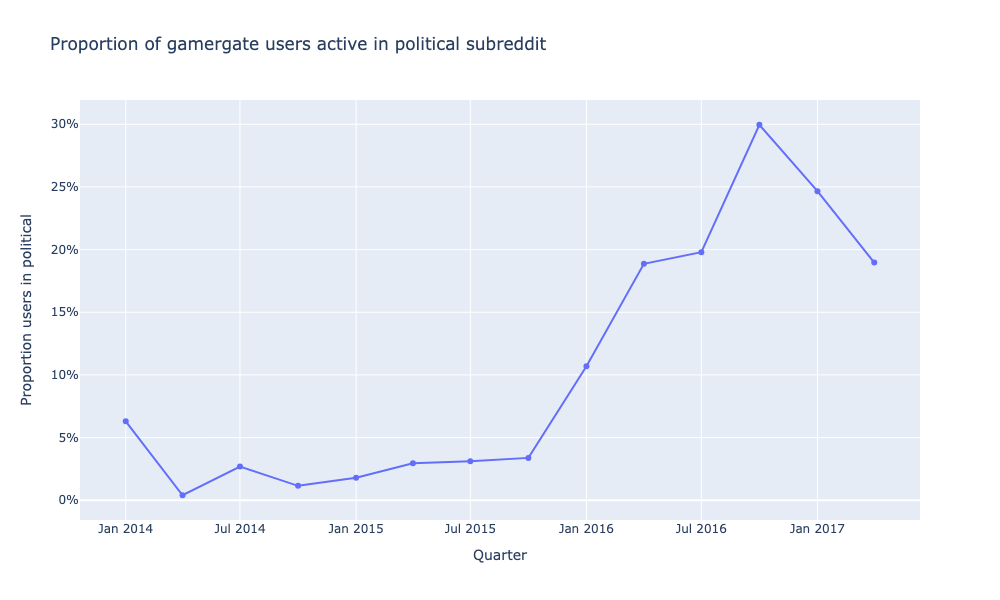

In [19]:
importlib.reload(politics)
politics.proportion_of_gg_in_politics(post_data, politics_data)

The rise during the 2016 presidential compaigns is clearly visible with a peak during the actual elections with 30% of the users in the selected subreddits having interacted in at least one of the 3 right to alt-right subreddits. This is a huge amount, a third of our 'attackers' subreddit evolving in alt-right sphere is indicative of the extremism promoted by gamergate.\
We can also see the steep decline after the election when the debate was maybe not as scaving. 

3.1.2 Gamer active in alt-right subreddits

Let's compare these value against those of a less polarized, and we expect less political subreddit, r/gaming.

In [20]:
gaming_dataset = RedditPostDataset('data/gamergate_post_data_old.csv')
gaming_data = gaming_dataset.data
gaming_data = gaming_data[gaming_data['SUBREDDIT'] == 'gaming']

/Users/katiahaefliger/Desktop/EPFL/MA 1/ADA/Project/ada-2025-project-othertagada/src/utils/politics.py:226: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/katiahaefliger/Desktop/EPFL/MA 1/ADA/Project/ada-2025-project-othertagada/src/utils/politics.py:227: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



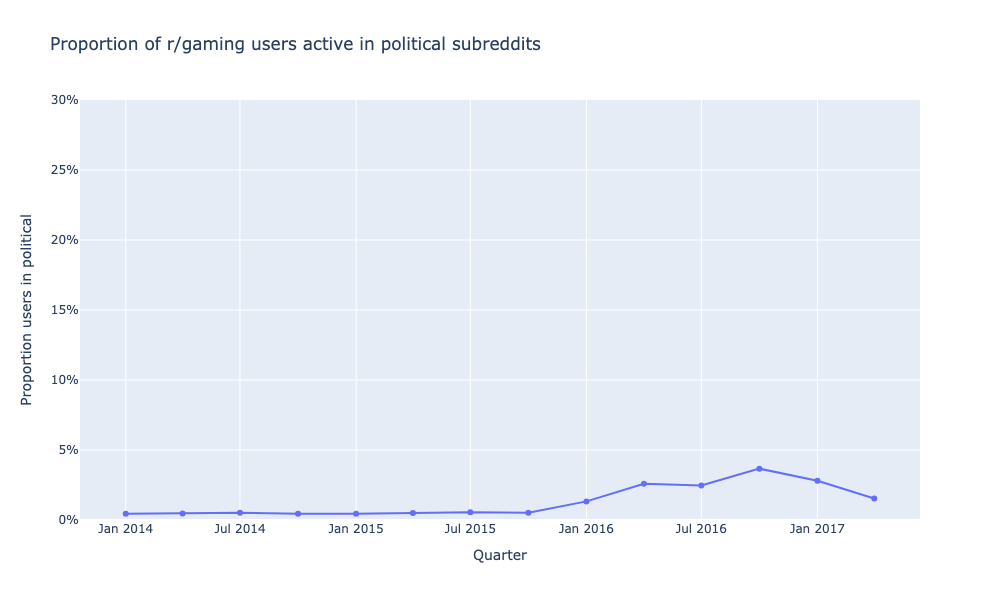

In [21]:
importlib.reload(politics)
politics.proportion_of_gamer_in_politics(gaming_data, politics_data)

We can observe the same bump in time for the election, but there is a huge difference in the scale of this bump. A lot more users in r/gaming were are active in the right/alt-right sphere, our assumption that gamergate was made of highly politicized users is verified.

### 3.2 Are more active users more politicaly engaged ?



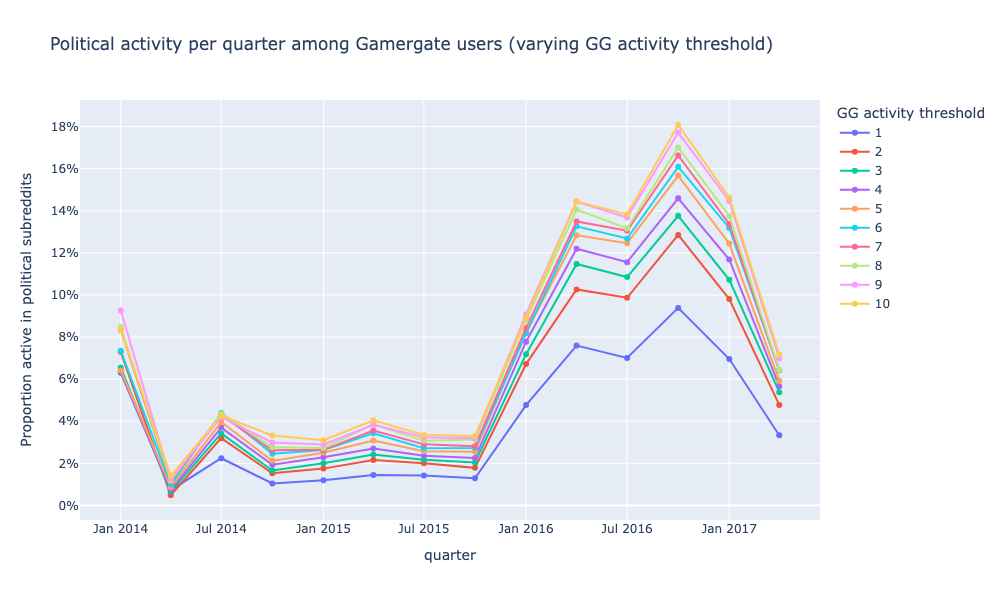

In [22]:
importlib.reload(politics)
politics.proportion_of_gg_in_politics_multiple_lines(post_data, politics_data)

/Users/katiahaefliger/Desktop/EPFL/MA 1/ADA/Project/ada-2025-project-othertagada/src/utils/politics.py:305: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



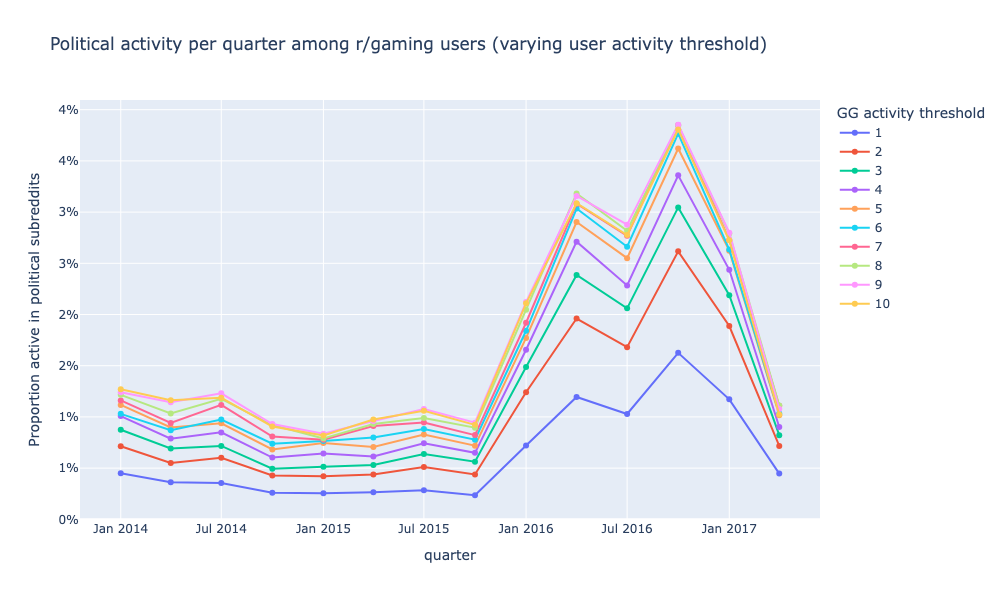

In [24]:
importlib.reload(politics)
politics.proportion_of_gaming_in_politics_multiple_lines(gaming_data, politics_data)

## 4. What becomes of these communites after the facts ?

While r/kotakuinaction and r/gamerghazi where created expressively with the goal of discussing the subject of GamerGate, these subreddits (like many others) do not die down suddenly after the events. These subreddits continue posting years after the peak of the conflict.

### 4.1 Decline in activity...

It is not surprising that the activity slows down significantly

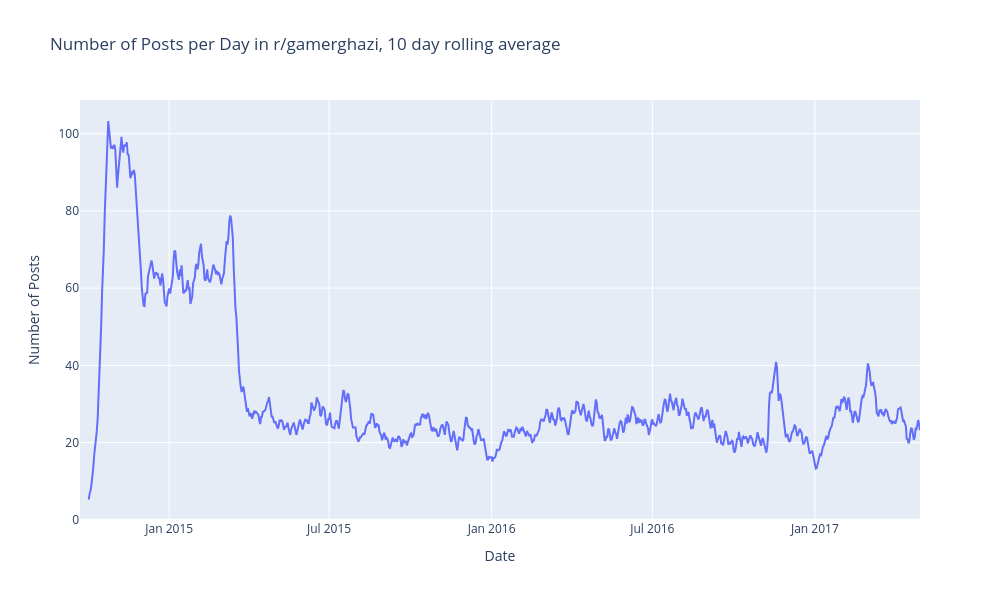

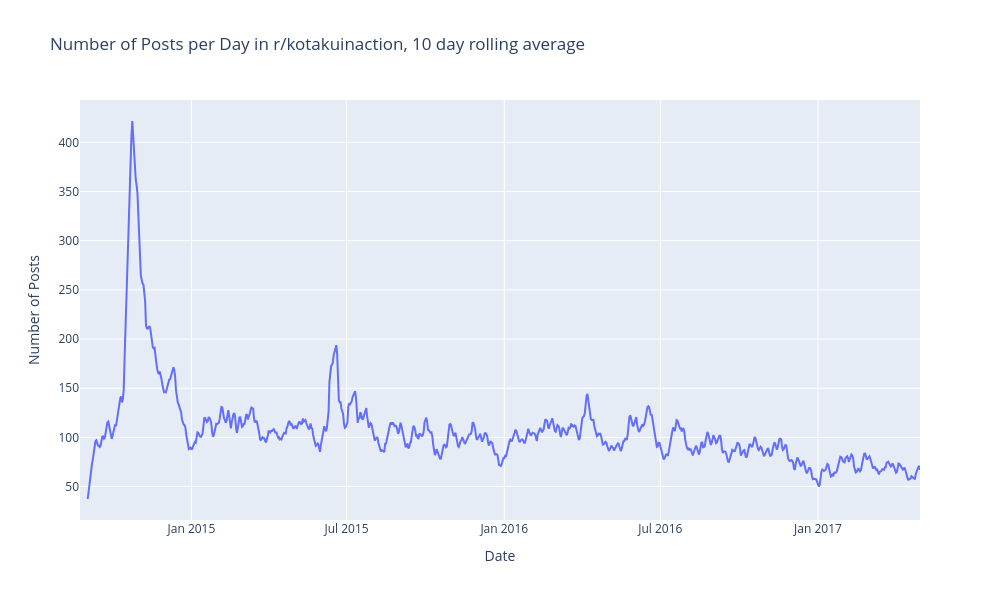

In [2]:
#plot nb of post per week both#
posts_per_day = pd.read_csv("data/zst_posts_per_day_per_sub.csv")
post_per_day_utils.plot_posts_per_day(["gamerghazi", "kotakuinaction"], posts_per_day)

### 4.2 ...But the activity is not null

So what are the discussions made of if there is still activity on those subreddits ? To analyze the changing trends in the topics discussed on each subreddit we have turn to NLP technics.



4.2.1 Creation of topic categories

We use the tool [Empath](https://arxiv.org/pdf/1602.06979) to create categories of topics related to our analysis. Empath is a NLP tool that utilizes deep learning to create custom lexicon of words from given seed words. These lexicons can then be applied to text documents to compute how much of the content of the text is part of the categories. This is a similar process as the LIWC scores discussed before. By looking at these Empath score overtime, we can get a good idea of the evolution of the content on the subreddit analyzed.

In [12]:
from empath import Empath
lexicon = Empath()

Empath even offers a model trained on data from reddit that is perfect for our analysis, sweet! We can now define some custom topics that we are interested to see the evolution over time.

Our custom topics :
* Gamergate : Everything related to the actual events that sparked gamergate
* Mysogyny : Signs of mysogyny, sexims and violence against women.
* Legal : Legal speech, trial 
* Incel : Incel retoric

In [13]:
lexicon.create_category("misogyny", ['sexism', 'insults', 'harassment', 'body', 'sexual'], model="reddit")
lexicon.create_category('gamergate', ['gaming', 'review', 'cheating'],model='reddit')
lexicon.create_category('legal', ['legal', 'trial', 'FBI', 'threat', 'doxxing'], model='reddit')
lexicon.create_category('incel', ['men', 'incel', 'society'], model='reddit')

["harassment", "misogyny", "victimization", "harrassment", "sexism", "slut_shaming", "slut-shaming", "misogyny", "objectification", "sexual_objectification", "misandry", "transphobia", "rape_culture", "transmisogyny", "physical_violence", "microaggressions", "toxic_masculinity", "misogynistic", "sexual_harassment", "misogyny", "misandry", "online_harassment", "physical_assault", "prejudice", "sexual", "rape", "denigration", "sexual_violence", "micro-aggressions", "bullying", "sexual_assault", "pedophilia", "shaming", "homophobia", "sexual_nature", "mysogyny", "actual_harassment", "internalized_misogyny", "masculinity", "victimhood", "microaggression", "sexist_behavior", "harrasment", "misgendering", "male_sexuality", "catcalling", "harmful_stereotypes", "male_violence", "transphobic", "misogynist", "gendered_insults", "gendered_violence", "street_harassment", "vilification", "transpeople", "male_entitlement", "even_rape", "victim_blaming", "rape_survivors", "micro-aggression", "dehuman

The lexicons given by empath seem relevant, term such as 'slut-shaming' and 'harrassement' were correctly infered from the given seed words for the category 'misogyny'. 

4.2.2 Monthly analysis

We compute the normalize values of relevance for each topic monthly to see the changing trends.\
First looking at r/kotakuinaction:

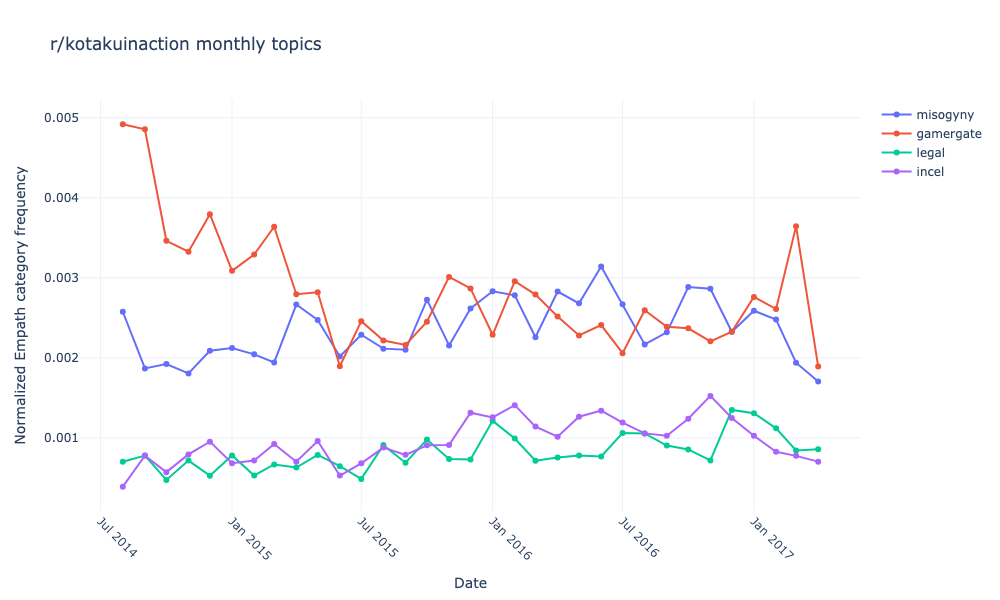

In [14]:
importlib.reload(topics_monthly)
collection_kia = topics_monthly.create_collection('outputs/subreddit_text_documents_monthly/kotakuinaction')
topics_monthly.plot_monthly_topic(collection_kia, lexicon)

For the topic of 'gamergate' we can see a high starting point that slowly goes down as time passes and the drama looses relevance, we have a real decline in interest in main topic. From the start misogyny is quite high and slowly goes up. The topic of 'incel' and 'legal' start quite low and also go up with time. These last two topics are way more precise than the two others we analyze so it is not surpising that they have lower value overall. 

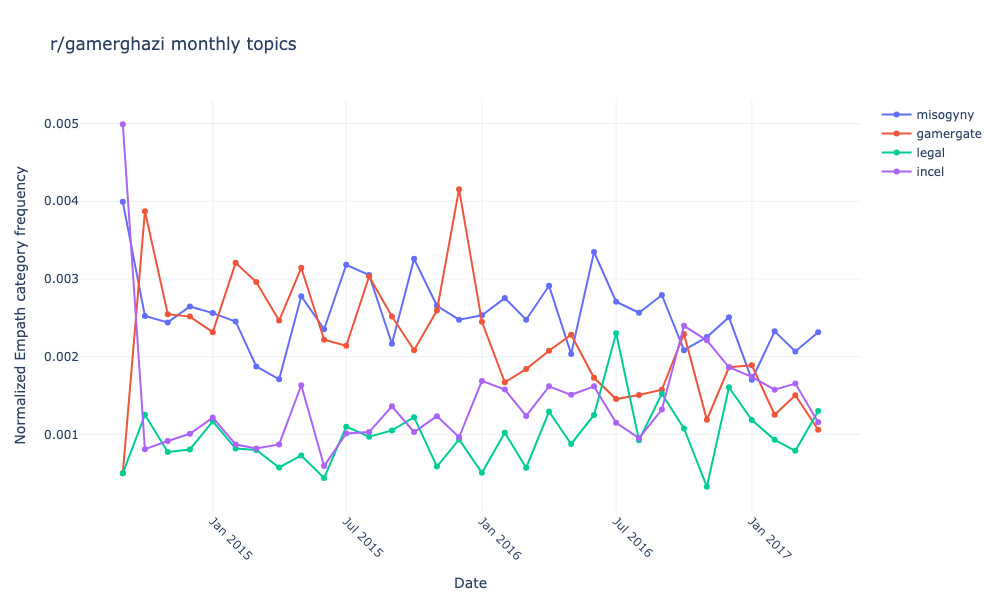

In [15]:
importlib.reload(topics_monthly)
collection_gia = topics_monthly.create_collection('outputs/subreddit_text_documents_monthly/gamerghazi')
topics_monthly.plot_monthly_topic(collection_gia, lexicon)

R/gamerghazi tells a different story, the topic of 'gamergate' is from the start not as relevant and 'misogyny' is globally higher. The subreddit r/gamergahzi is not as much invested in tha actual events but more on discussing what came of the hate compaign. These is even more seen in the aftermath, where r/gamerghazi is mostly used to discuss the incel movement that has come up from the events. Legal picks up significantly in importance as the legal ramifications of GamerGate slowly surface.

4.2.3 Comparaison with baseline

Just to be sure that our technic using Empath is working properly, let's see what happens when we compute the same values for a subreddit that is not part of the gamergate drama. We chose the very active r/gaming subreddit.

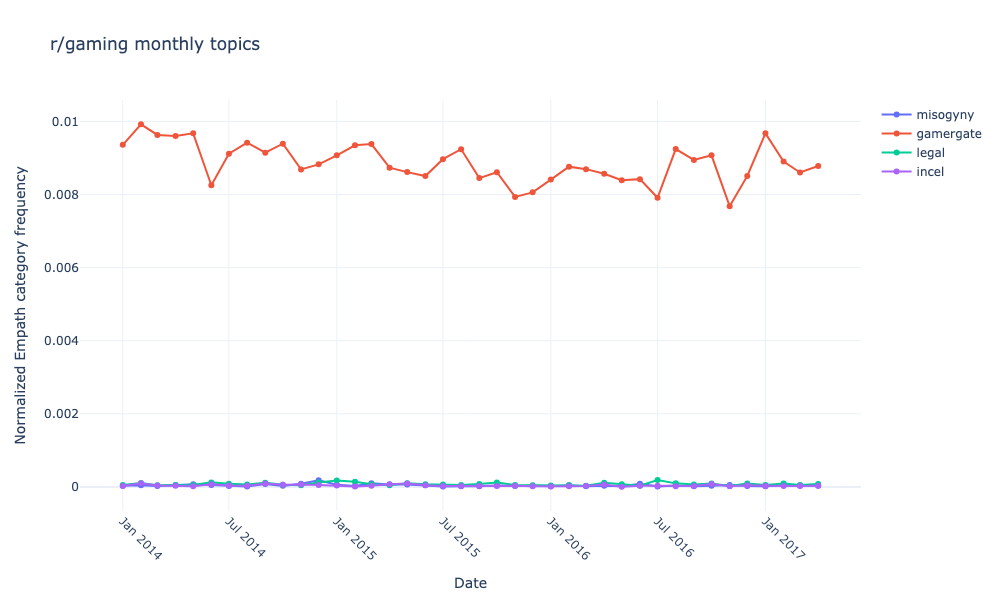

In [16]:
importlib.reload(topics_monthly)
collection_gaming = topics_monthly.create_collection('outputs/subreddit_text_documents_monthly_gaming/gaming')
topics_monthly.plot_monthly_topic(collection_gaming, lexicon)

The topic of gamergate are very high, this is explained by the fact that one of the seed word given for this category was 'gaming', which is a word that is most certainly well found in r/gaming. In contrast, the other topics look almost irrelevant for this subreddit, this confirm that the sudreddits r/kotakuinaction and r/gamerghazi have a high value for the topic of misogyny and incel behaviour than a subreddit not linked to the events. 

## 5. Conclusion